# Workshop 10 - Training Neural Networks (Learning rate scheduling and optimisers)

Code for workshop 10.  This will use Keras (within tensorflow v2)

In [39]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os, time
import pandas as pd

# Deep Learning imports
import tensorflow as tf
from tensorflow import keras

# To plot nice figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
mpl.rc('figure', dpi=100)
import seaborn as sns; sns.set()

In [40]:
# Check the versions are OK (both should be 2 or more)
print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


## Load data
We will use MNIST, which is a set of small images (28x28) that contain 10 digits - see below for class names and an example image.

In [41]:
# This is a built-in data for keras, so easily accessible
mnist = keras.datasets.mnist
(X_train_full, y_train_full), (X_test, y_test) = mnist.load_data()

In [42]:
# Let's see how big it is
print(X_train_full.shape)
print(X_test.shape)
n_total = X_train_full.shape[0]

(60000, 28, 28)
(10000, 28, 28)


float64
float64
7


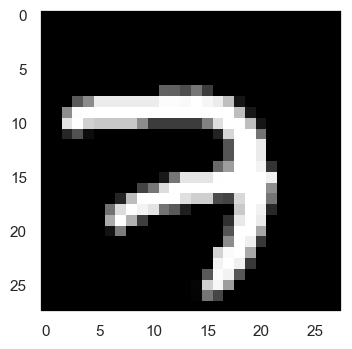

In [43]:
# Scale the data appropriately (it starts with max of 255, but we want max of 1)
# We will do this "by hand" here, but we could build a pipeline scaler for this instead
# We also split the training set given to us into training and validation subsets
#   The value of 5000 samples as the size of the validation set is an arbitrary choice
X_test = X_test/255.0
X_valid, X_train = X_train_full[:5000]/255.0, X_train_full[5000:]/255.0 
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
class_names = np.array([ "0","1","2","3","4","5","6","7","8","9" ])

# Inspect some aspects of the data (in general, you should play around with the data 
#                                   more than this to get a feel for it)
# Check that scaled types are appropriate
print(X_train.dtype)
print(X_valid.dtype)
# Look at first item
print(class_names[y_train[0]])
plt.imshow(X_train[0,:,:], cmap='gray')
plt.grid(False)
plt.show()

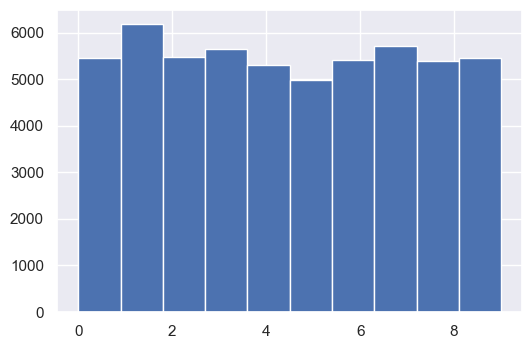

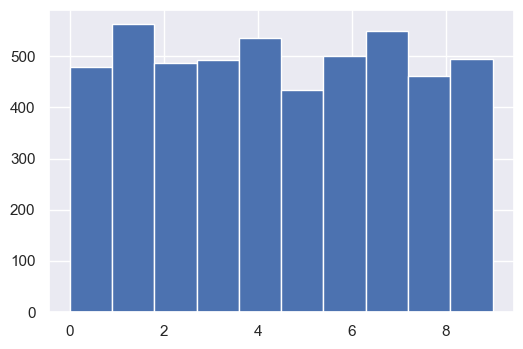

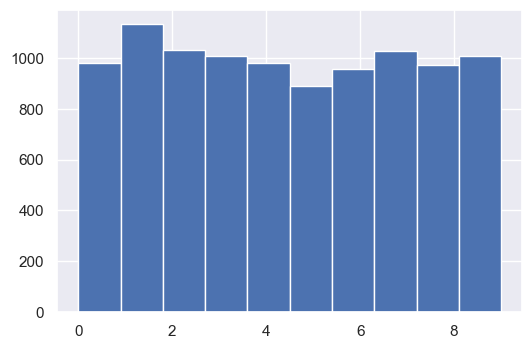

In [44]:
# Let's look at the distribution of labels in the training, validation and test sets
plt.hist(y_train)
plt.show()
plt.hist(y_valid)
plt.show()
plt.hist(y_test)
plt.show()

## Simple Neural Network Code with Keras

We will use the keras version built into tensorflow version 2.
It is remarkably simple for building, training and evaluating networks.

In [45]:
# Some key parameters
n_train = 300
n_valid = 100
# Define the number and size of hidden layers
hiddensizes = [16, 32, 16]
# Define the activation function to be used by hidden layers
#actfn = "relu"
actfn = "elu"
# Optimiser and learning rate
optimizer = keras.optimizers.SGD
learningrate = 0.01   # SGD default value
# Set size of batch and number of epochs
batch_size = 32
n_epochs = 20

In [46]:
# Build a CNN
def model_cnn_factory(hiddensizes, actfn, optimizer, learningrate=0):
    model = keras.models.Sequential()
    model.add(keras.layers.Conv2D(filters=hiddensizes[0], kernel_size=3, strides=1, activation=actfn, padding="same", 
                                  input_shape=[28, 28, 1]))    # input layer goes into this 2D convolution
    model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    for n in hiddensizes[1:-1]:
        model.add(keras.layers.Conv2D(filters=n, kernel_size=3, strides=1, padding="same", activation=actfn))  # 2nd Conv
        model.add(keras.layers.MaxPooling2D(pool_size=2))          # Pool (downsize)
    model.add(keras.layers.Conv2D(filters=hiddensizes[-1], kernel_size=3, strides=1, padding="same", activation=actfn))  # 2nd Conv
    model.add(keras.layers.Flatten())                          # unravel into a 1D vector
    model.add(keras.layers.Dense(10, activation = "softmax"))  # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])   
    return model

In [47]:
# Optional aside: the CNN can become a Fully Convolutional Network (FCN) by replacing the Flatten and Dense lines with
#   model.add(keras.layers.Conv2D(filters=10, kernel_size=7, padding="valid", activation="softmax"))
# This uses a kernel equal to the full image size (at this point) to generate a single output per filter 
#  which requires the convolution to be "valid" and not "same"

In [48]:
def model_dense_factory(hiddensizes, actfn, optimizer, learningrate):
    model = keras.models.Sequential()
    model.add(keras.layers.Flatten(input_shape = [28, 28, 1]))    # always have same sized inputs
    for n in hiddensizes:
        model.add(keras.layers.Dense(n, activation = actfn))
    model.add(keras.layers.Dense(10, activation = "softmax"))   # always have 10 classes
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer(learning_rate=learningrate), metrics=["accuracy"])
    return model

In [49]:
# Reshape the data to be shape [Nx, Ny, 1]  (previously 2D was fine, but for CNN we need depth too)
X_train = X_train.reshape((-1, 28, 28, 1))
X_valid = X_valid.reshape((-1, 28, 28, 1))
X_test = X_test.reshape((-1, 28, 28, 1))

In [50]:
# Early stopping callback - this is executed when fitting and will stop and restore best result
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='???', patience=5, restore_best_weights=True) 

In [51]:
### CHANGE IN CODE ###

def do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size, further_callbacks=[]):
    if further_callbacks != []:
        callbacks = further_callbacks
    else:
        callbacks = [early_stopping_cb]
    model = model_???_factory(hiddensizes, actfn, optimizer, learningrate)
    history = model.fit(X_train[:n_train,:,:,:], y_train[:n_train], epochs=n_epochs, callbacks = callbacks,
                        validation_data=(X_valid[:n_valid,:,:,:], y_valid[:n_valid]))
    max_val_acc = np.max(history.history['val_accuracy'])
    return (max_val_acc, history, model)

In [52]:
valacc, history, model = do_all(hiddensizes, actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
model.summary()

Epoch 1/20
10/10 [==============================] - 1s 29ms/step - loss: 2.2776 - accuracy: 0.1200 - val_loss: 2.2682 - val_accuracy: 0.1400
Epoch 2/20
10/10 [==============================] - 0s 13ms/step - loss: 2.2452 - accuracy: 0.1900 - val_loss: 2.2389 - val_accuracy: 0.2400
Epoch 3/20
10/10 [==============================] - 0s 13ms/step - loss: 2.2135 - accuracy: 0.2833 - val_loss: 2.2094 - val_accuracy: 0.3700
Epoch 4/20
10/10 [==============================] - 0s 12ms/step - loss: 2.1827 - accuracy: 0.3667 - val_loss: 2.1806 - val_accuracy: 0.3800
Epoch 5/20
10/10 [==============================] - 0s 12ms/step - loss: 2.1488 - accuracy: 0.4067 - val_loss: 2.1448 - val_accuracy: 0.3900
Epoch 6/20
10/10 [==============================] - 0s 12ms/step - loss: 2.1073 - accuracy: 0.4133 - val_loss: 2.1075 - val_accuracy: 0.4200
Epoch 7/20
10/10 [==============================] - 0s 12ms/step - loss: 2.0629 - accuracy: 0.4467 - val_loss: 2.0615 - val_accuracy: 0.4500
Epoch 8/20
10

In [53]:
def plot_history(history):
    # Plot the results (shifting validation curves appropriately)
    plt.figure(figsize=(8,5))
    n = len(history.history['accuracy'])
    plt.plot(np.arange(0,n),history.history['accuracy'], color='orange')
    plt.plot(np.arange(0,n),history.history['loss'],'b')
    plt.plot(np.arange(0,n)+0.5,history.history['val_accuracy'],'r')  # offset both validation curves
    plt.plot(np.arange(0,n)+0.5,history.history['val_loss'],'g')
    plt.legend(['Train Acc','Train Loss','Val Acc','Val Loss'])
    plt.grid(True)
    plt.gca().set_ylim(0, 1) # set the vertical range to [0-1] 
    plt.xlabel('Epochs')
    plt.show() 

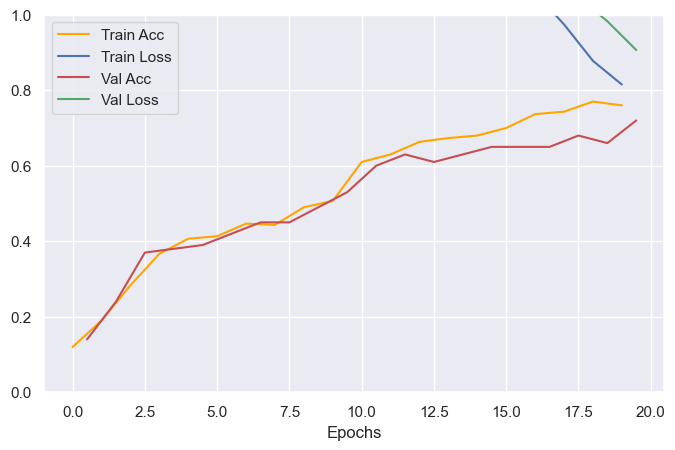

In [54]:
plot_history(history)

# Manually exploring the learning rate



Epoch 1/20
10/10 [==============================] - 3s 288ms/step - loss: 2.2477 - accuracy: 0.2500 - val_loss: 2.1631 - val_accuracy: 0.4300
Epoch 2/20
10/10 [==============================] - 0s 11ms/step - loss: 2.1085 - accuracy: 0.4233 - val_loss: 1.9733 - val_accuracy: 0.6800
Epoch 3/20
10/10 [==============================] - 0s 11ms/step - loss: 1.8515 - accuracy: 0.6067 - val_loss: 1.5589 - val_accuracy: 0.7400
Epoch 4/20
10/10 [==============================] - 0s 15ms/step - loss: 1.3454 - accuracy: 0.7033 - val_loss: 0.9934 - val_accuracy: 0.7100
Epoch 5/20
10/10 [==============================] - 0s 12ms/step - loss: 0.8592 - accuracy: 0.7800 - val_loss: 2.1012 - val_accuracy: 0.2300
Epoch 6/20
10/10 [==============================] - 0s 13ms/step - loss: 0.8928 - accuracy: 0.7433 - val_loss: 0.6486 - val_accuracy: 0.8300
Epoch 7/20
10/10 [==============================] - 0s 12ms/step - loss: 0.5402 - accuracy: 0.8667 - val_loss: 0.7501 - val_accuracy: 0.7300
Epoch 8/20
1

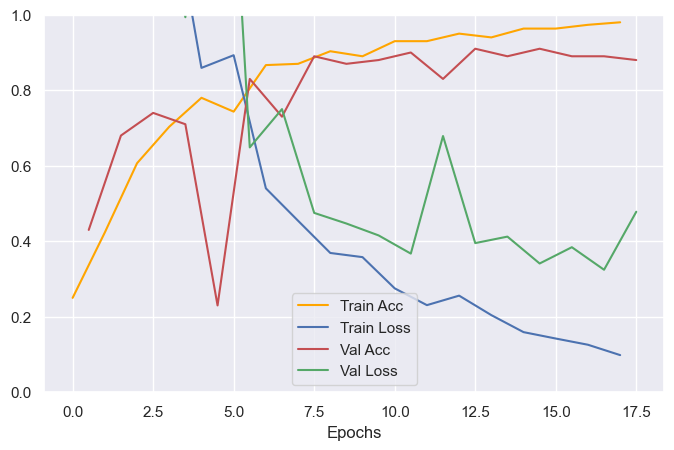

Epoch 1/20
10/10 [==============================] - 1s 27ms/step - loss: 2.2976 - accuracy: 0.1333 - val_loss: 2.2452 - val_accuracy: 0.3300
Epoch 2/20
10/10 [==============================] - 0s 12ms/step - loss: 2.2125 - accuracy: 0.3167 - val_loss: 2.1507 - val_accuracy: 0.4800
Epoch 3/20
10/10 [==============================] - 0s 13ms/step - loss: 2.1107 - accuracy: 0.4167 - val_loss: 2.0126 - val_accuracy: 0.5800
Epoch 4/20
10/10 [==============================] - 0s 13ms/step - loss: 1.9228 - accuracy: 0.5267 - val_loss: 1.7428 - val_accuracy: 0.5100
Epoch 5/20
10/10 [==============================] - 0s 12ms/step - loss: 1.6281 - accuracy: 0.5833 - val_loss: 1.4274 - val_accuracy: 0.6900
Epoch 6/20
10/10 [==============================] - 0s 13ms/step - loss: 1.2768 - accuracy: 0.6733 - val_loss: 1.1093 - val_accuracy: 0.7500
Epoch 7/20
10/10 [==============================] - 0s 13ms/step - loss: 0.9472 - accuracy: 0.7300 - val_loss: 0.8920 - val_accuracy: 0.7300
Epoch 8/20
10

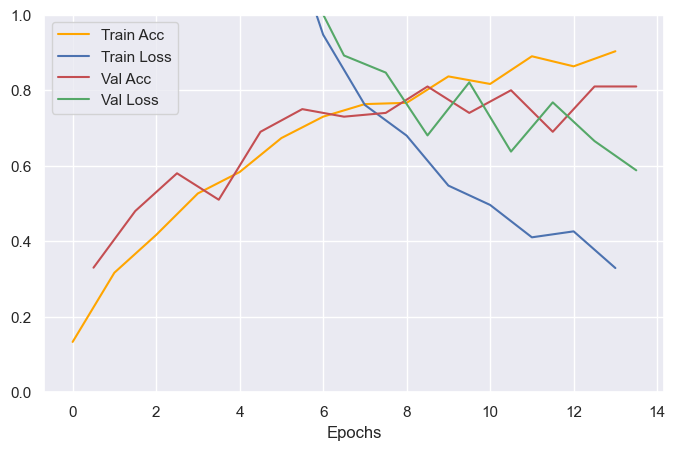

Epoch 1/20
10/10 [==============================] - 0s 23ms/step - loss: 2.3024 - accuracy: 0.1267 - val_loss: 2.2570 - val_accuracy: 0.1800
Epoch 2/20
10/10 [==============================] - 0s 14ms/step - loss: 2.2298 - accuracy: 0.1833 - val_loss: 2.1932 - val_accuracy: 0.2800
Epoch 3/20
10/10 [==============================] - 0s 14ms/step - loss: 2.1536 - accuracy: 0.3267 - val_loss: 2.1139 - val_accuracy: 0.5300
Epoch 4/20
10/10 [==============================] - 0s 12ms/step - loss: 2.0575 - accuracy: 0.4900 - val_loss: 1.9940 - val_accuracy: 0.5600
Epoch 5/20
10/10 [==============================] - 0s 13ms/step - loss: 1.8986 - accuracy: 0.5900 - val_loss: 1.8208 - val_accuracy: 0.5500
Epoch 6/20
10/10 [==============================] - 0s 13ms/step - loss: 1.6632 - accuracy: 0.6567 - val_loss: 1.4951 - val_accuracy: 0.7000
Epoch 7/20
10/10 [==============================] - 0s 12ms/step - loss: 1.3212 - accuracy: 0.6933 - val_loss: 1.1617 - val_accuracy: 0.7400
Epoch 8/20
10

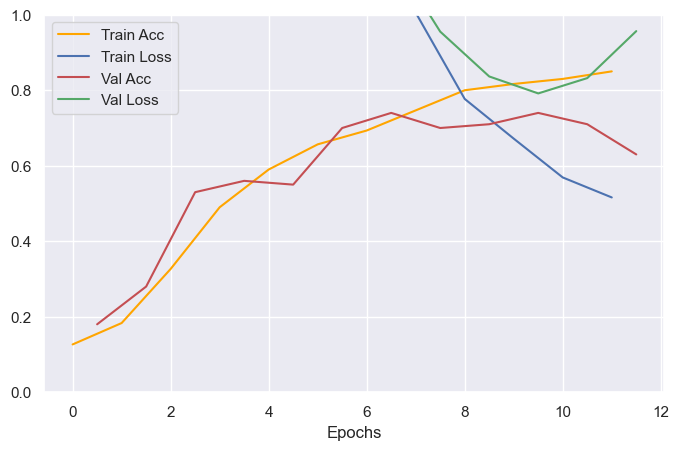

Epoch 1/20
10/10 [==============================] - 0s 21ms/step - loss: 2.2756 - accuracy: 0.1933 - val_loss: 2.2364 - val_accuracy: 0.2300
Epoch 2/20
10/10 [==============================] - 0s 12ms/step - loss: 2.2222 - accuracy: 0.3200 - val_loss: 2.1868 - val_accuracy: 0.4400
Epoch 3/20
10/10 [==============================] - 0s 11ms/step - loss: 2.1634 - accuracy: 0.4833 - val_loss: 2.1248 - val_accuracy: 0.4900
Epoch 4/20
10/10 [==============================] - 0s 12ms/step - loss: 2.0942 - accuracy: 0.5067 - val_loss: 2.0448 - val_accuracy: 0.6300
Epoch 5/20
10/10 [==============================] - 0s 14ms/step - loss: 1.9980 - accuracy: 0.5900 - val_loss: 1.9303 - val_accuracy: 0.6600
Epoch 6/20
10/10 [==============================] - 0s 13ms/step - loss: 1.8652 - accuracy: 0.6533 - val_loss: 1.7681 - val_accuracy: 0.7000
Epoch 7/20
10/10 [==============================] - 0s 13ms/step - loss: 1.6755 - accuracy: 0.6933 - val_loss: 1.5523 - val_accuracy: 0.7400
Epoch 8/20
10

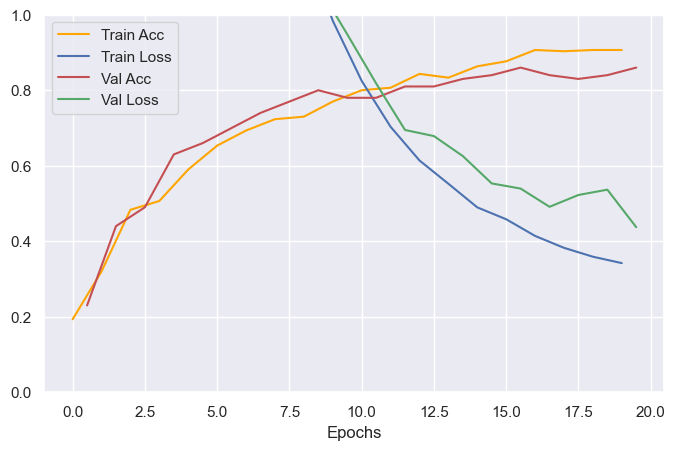

Epoch 1/20
10/10 [==============================] - 1s 27ms/step - loss: 2.3045 - accuracy: 0.0867 - val_loss: 2.2810 - val_accuracy: 0.1400
Epoch 2/20
10/10 [==============================] - 0s 13ms/step - loss: 2.2685 - accuracy: 0.1933 - val_loss: 2.2458 - val_accuracy: 0.2300
Epoch 3/20
10/10 [==============================] - 0s 13ms/step - loss: 2.2342 - accuracy: 0.2100 - val_loss: 2.2127 - val_accuracy: 0.2400
Epoch 4/20
10/10 [==============================] - 0s 13ms/step - loss: 2.2002 - accuracy: 0.2300 - val_loss: 2.1783 - val_accuracy: 0.2900
Epoch 5/20
10/10 [==============================] - 0s 14ms/step - loss: 2.1635 - accuracy: 0.2433 - val_loss: 2.1396 - val_accuracy: 0.3600
Epoch 6/20
10/10 [==============================] - 0s 14ms/step - loss: 2.1219 - accuracy: 0.3133 - val_loss: 2.0983 - val_accuracy: 0.4300
Epoch 7/20
10/10 [==============================] - 0s 13ms/step - loss: 2.0768 - accuracy: 0.4100 - val_loss: 2.0512 - val_accuracy: 0.4900
Epoch 8/20
10

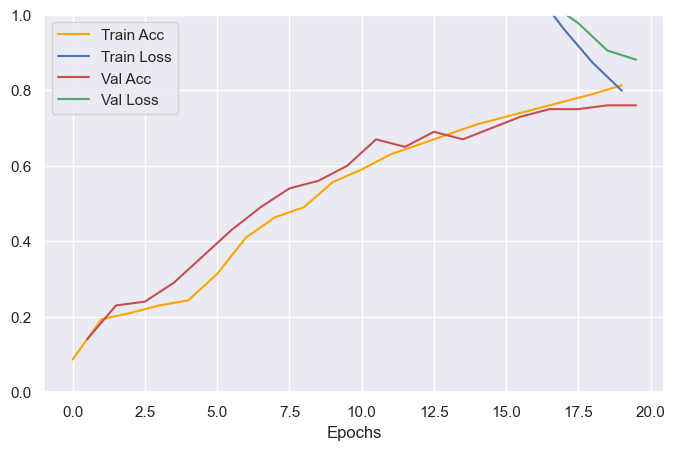

Epoch 1/20
10/10 [==============================] - 1s 30ms/step - loss: 2.2978 - accuracy: 0.1267 - val_loss: 2.3016 - val_accuracy: 0.1300
Epoch 2/20
10/10 [==============================] - 0s 13ms/step - loss: 2.2878 - accuracy: 0.1500 - val_loss: 2.2913 - val_accuracy: 0.1300
Epoch 3/20
10/10 [==============================] - 0s 14ms/step - loss: 2.2780 - accuracy: 0.1700 - val_loss: 2.2817 - val_accuracy: 0.1400
Epoch 4/20
10/10 [==============================] - 0s 13ms/step - loss: 2.2683 - accuracy: 0.1967 - val_loss: 2.2731 - val_accuracy: 0.1400
Epoch 5/20
10/10 [==============================] - 0s 13ms/step - loss: 2.2594 - accuracy: 0.2167 - val_loss: 2.2634 - val_accuracy: 0.1800
Epoch 6/20
10/10 [==============================] - 0s 13ms/step - loss: 2.2497 - accuracy: 0.2300 - val_loss: 2.2540 - val_accuracy: 0.2000
Epoch 7/20
10/10 [==============================] - 0s 13ms/step - loss: 2.2399 - accuracy: 0.2367 - val_loss: 2.2444 - val_accuracy: 0.2000
Epoch 8/20
10

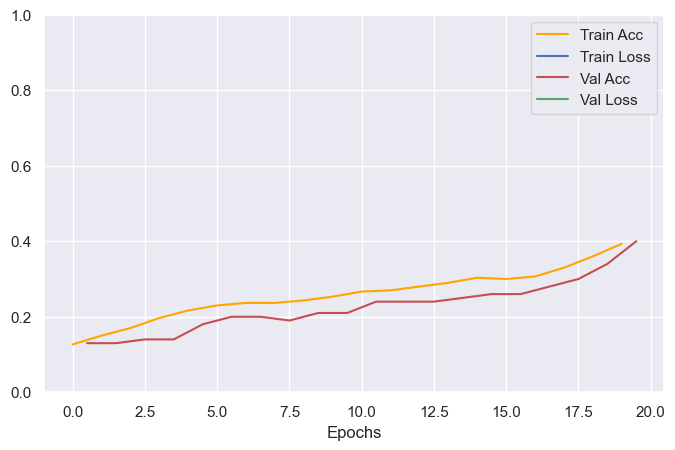

[[0.05, 0.9100000262260437], [0.04, 0.8100000023841858], [0.03, 0.7400000095367432], [0.02, 0.8600000143051147], [0.01, 0.7599999904632568], [0.005, 0.4000000059604645]]


In [55]:
# Learning rate
res=[]
for lr in [???]:
    valacc, history, discard = do_all(hiddensizes, actfn, optimizer, lr*learningrate, n_train, n_valid, n_epochs, batch_size)
    print(f'Network configuration = {hiddensizes}')
    plot_history(history)
    res += [[lr*learningrate,valacc]]
print(res)

Text(0, 0.5, 'Val Accuracy')

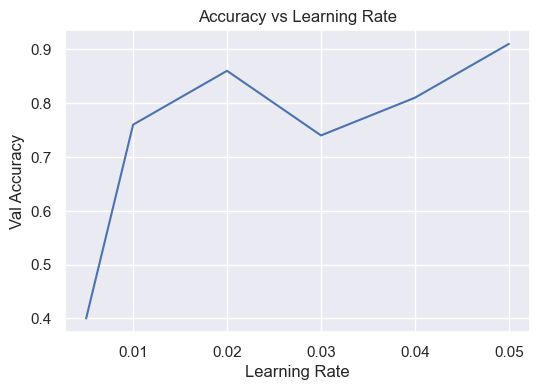

In [56]:
res=np.array(res)
plt.plot(res[:,0],res[:,1])
plt.title('Accuracy vs Learning Rate')
plt.xlabel('Learning Rate')
plt.ylabel('Val Accuracy')

## Comment
It can be seen from the curve that over this range the accuracy improves with the learning rate, but it isn't quite that simple. If you look at the learning curves you will see that they are all learning, just some are slower and the arbitrary cut-off in the number of epochs has a more dramatic effect in some than others.  All could probably benefit from more epochs.  Also, a higher learning rate might still be effective, and should be explored, but it is important to keep checking the stability as setting the learning rate at the higher rates can induce instability.

Epoch 1/20
10/10 [==============================] - 0s 21ms/step - loss: 2.3145 - accuracy: 0.0767 - val_loss: 2.2816 - val_accuracy: 0.1600
Epoch 2/20
10/10 [==============================] - 0s 12ms/step - loss: 2.2716 - accuracy: 0.1433 - val_loss: 2.2435 - val_accuracy: 0.2200
Epoch 3/20
10/10 [==============================] - 0s 12ms/step - loss: 2.2280 - accuracy: 0.1967 - val_loss: 2.2036 - val_accuracy: 0.2300
Epoch 4/20
10/10 [==============================] - 0s 10ms/step - loss: 2.1813 - accuracy: 0.2500 - val_loss: 2.1568 - val_accuracy: 0.3100
Epoch 5/20
10/10 [==============================] - 0s 11ms/step - loss: 2.1281 - accuracy: 0.3200 - val_loss: 2.1039 - val_accuracy: 0.4000
Epoch 6/20
10/10 [==============================] - 0s 11ms/step - loss: 2.0635 - accuracy: 0.3833 - val_loss: 2.0344 - val_accuracy: 0.5800
Epoch 7/20
10/10 [==============================] - 0s 9ms/step - loss: 1.9824 - accuracy: 0.5233 - val_loss: 1.9454 - val_accuracy: 0.5900
Epoch 8/20
10/

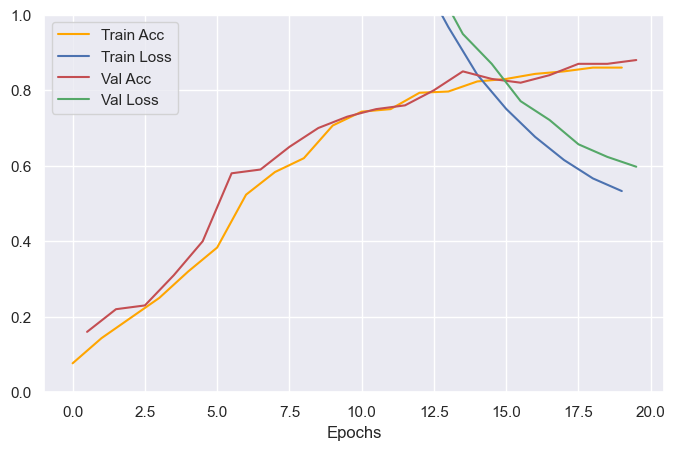

Epoch 1/20
10/10 [==============================] - 1s 25ms/step - loss: 2.2943 - accuracy: 0.0933 - val_loss: 2.2281 - val_accuracy: 0.2600
Epoch 2/20
10/10 [==============================] - 0s 12ms/step - loss: 2.1989 - accuracy: 0.2800 - val_loss: 2.1449 - val_accuracy: 0.4100
Epoch 3/20
10/10 [==============================] - 0s 11ms/step - loss: 2.1114 - accuracy: 0.3700 - val_loss: 2.0568 - val_accuracy: 0.5400
Epoch 4/20
10/10 [==============================] - 0s 11ms/step - loss: 2.0109 - accuracy: 0.5267 - val_loss: 1.9530 - val_accuracy: 0.6400
Epoch 5/20
10/10 [==============================] - 0s 12ms/step - loss: 1.8866 - accuracy: 0.6567 - val_loss: 1.8219 - val_accuracy: 0.7000
Epoch 6/20
10/10 [==============================] - 0s 10ms/step - loss: 1.7376 - accuracy: 0.6967 - val_loss: 1.6668 - val_accuracy: 0.7500
Epoch 7/20
10/10 [==============================] - 0s 12ms/step - loss: 1.5684 - accuracy: 0.7333 - val_loss: 1.4969 - val_accuracy: 0.7200
Epoch 8/20
10

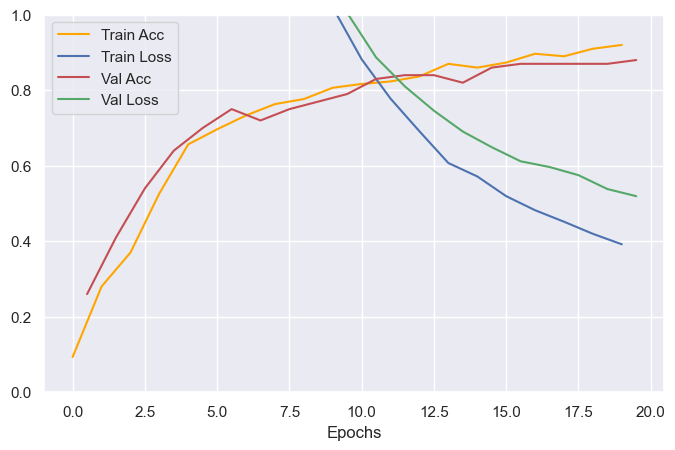

Epoch 1/20
10/10 [==============================] - 1s 26ms/step - loss: 2.3431 - accuracy: 0.0600 - val_loss: 2.3094 - val_accuracy: 0.1100
Epoch 2/20
10/10 [==============================] - 0s 13ms/step - loss: 2.3103 - accuracy: 0.0733 - val_loss: 2.2837 - val_accuracy: 0.1500
Epoch 3/20
10/10 [==============================] - 0s 12ms/step - loss: 2.2842 - accuracy: 0.1233 - val_loss: 2.2615 - val_accuracy: 0.1600
Epoch 4/20
10/10 [==============================] - 0s 11ms/step - loss: 2.2601 - accuracy: 0.1400 - val_loss: 2.2400 - val_accuracy: 0.1700
Epoch 5/20
10/10 [==============================] - 0s 11ms/step - loss: 2.2359 - accuracy: 0.1533 - val_loss: 2.2164 - val_accuracy: 0.1700
Epoch 6/20
10/10 [==============================] - 0s 11ms/step - loss: 2.2100 - accuracy: 0.1633 - val_loss: 2.1914 - val_accuracy: 0.2200
Epoch 7/20
10/10 [==============================] - 0s 11ms/step - loss: 2.1825 - accuracy: 0.2233 - val_loss: 2.1638 - val_accuracy: 0.2700
Epoch 8/20
10

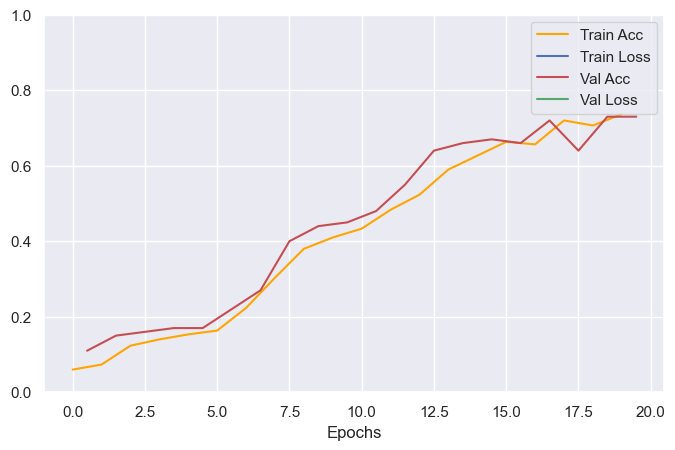

[[1, 0.8799999952316284], [2, 0.8799999952316284], [3, 0.7300000190734863]]


In [57]:
# Number of layers
res=[]
for n in [???]:
    valacc, history, discard = do_all(hiddensizes[:n], actfn, optimizer, learningrate, n_train, n_valid, n_epochs, batch_size)
    print(f'Learning rate = {learningrate}')
    plot_history(history)
    res += [[n,valacc]]
print(res)

Text(0, 0.5, 'Val Accuracy')

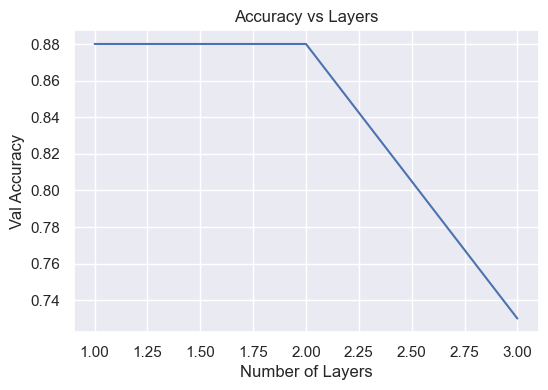

In [58]:
res=np.array(res)
plt.plot(res[:,0],res[:,1])
plt.title('Accuracy vs Layers')
plt.xlabel('Number of Layers')
plt.ylabel('Val Accuracy')

## Comment
The accuracy seems to reduce with the number of layers here, except that if you look at the learning curves then you can see that this is probably not true if the number of epochs was extended. Hence it is really impossible to say from this test what is the optimal number of layers, as it is necessary to run each network to convergence, where a steady maximum accuracy value is obtained (i.e. a plateau). This may well show the opposite result, where the larger network does better, or it might show that either of the others are better - it just isn't possible to know unless you do the experiment, as things depend in a complicated way on the network, on the dataset and on the task.

# Exploring optimizers

Let us compare different optimizers on the same task.

Epoch 1/20
10/10 [==============================] - 1s 27ms/step - loss: 2.3182 - accuracy: 0.0667 - val_loss: 2.3013 - val_accuracy: 0.1200
Epoch 2/20
10/10 [==============================] - 0s 14ms/step - loss: 2.3024 - accuracy: 0.0800 - val_loss: 2.2860 - val_accuracy: 0.1400
Epoch 3/20
10/10 [==============================] - 0s 13ms/step - loss: 2.2872 - accuracy: 0.1233 - val_loss: 2.2730 - val_accuracy: 0.1500
Epoch 4/20
10/10 [==============================] - 0s 13ms/step - loss: 2.2737 - accuracy: 0.1433 - val_loss: 2.2596 - val_accuracy: 0.1800
Epoch 5/20
10/10 [==============================] - 0s 13ms/step - loss: 2.2598 - accuracy: 0.2267 - val_loss: 2.2455 - val_accuracy: 0.2800
Epoch 6/20
10/10 [==============================] - 0s 13ms/step - loss: 2.2455 - accuracy: 0.2333 - val_loss: 2.2305 - val_accuracy: 0.3300
Epoch 7/20
10/10 [==============================] - 0s 12ms/step - loss: 2.2297 - accuracy: 0.2700 - val_loss: 2.2144 - val_accuracy: 0.3800
Epoch 8/20
10

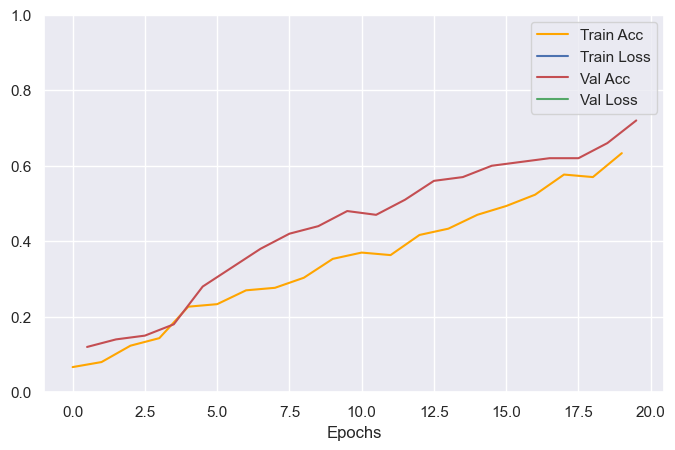

Epoch 1/20
10/10 [==============================] - 1s 24ms/step - loss: 2.2304 - accuracy: 0.1767 - val_loss: 2.0611 - val_accuracy: 0.4100
Epoch 2/20
10/10 [==============================] - 0s 11ms/step - loss: 1.9085 - accuracy: 0.4333 - val_loss: 1.6668 - val_accuracy: 0.7600
Epoch 3/20
10/10 [==============================] - 0s 13ms/step - loss: 1.4184 - accuracy: 0.6900 - val_loss: 1.1420 - val_accuracy: 0.7600
Epoch 4/20
10/10 [==============================] - 0s 12ms/step - loss: 0.9122 - accuracy: 0.7633 - val_loss: 0.7514 - val_accuracy: 0.8500
Epoch 5/20
10/10 [==============================] - 0s 13ms/step - loss: 0.6234 - accuracy: 0.7833 - val_loss: 0.5902 - val_accuracy: 0.8400
Epoch 6/20
10/10 [==============================] - 0s 13ms/step - loss: 0.4940 - accuracy: 0.8500 - val_loss: 0.5382 - val_accuracy: 0.8600
Epoch 7/20
10/10 [==============================] - 0s 13ms/step - loss: 0.4111 - accuracy: 0.8633 - val_loss: 0.5023 - val_accuracy: 0.8600
Epoch 8/20
10

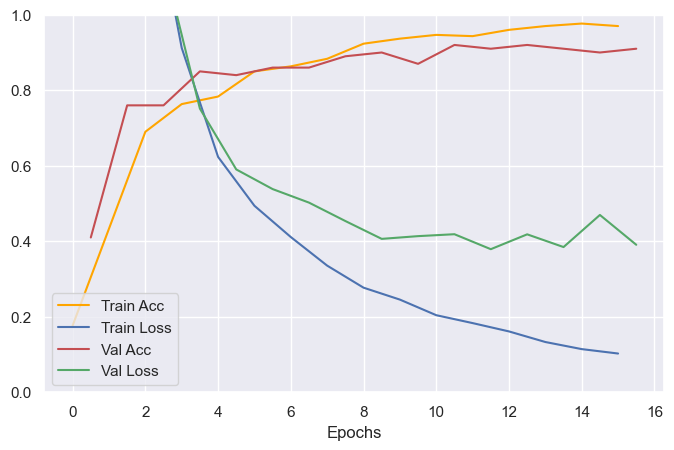

Epoch 1/20
10/10 [==============================] - 1s 27ms/step - loss: 2.2150 - accuracy: 0.1900 - val_loss: 2.0399 - val_accuracy: 0.4300
Epoch 2/20
10/10 [==============================] - 0s 15ms/step - loss: 1.8609 - accuracy: 0.5133 - val_loss: 1.5084 - val_accuracy: 0.6200
Epoch 3/20
10/10 [==============================] - 0s 14ms/step - loss: 1.2727 - accuracy: 0.6933 - val_loss: 1.0650 - val_accuracy: 0.6700
Epoch 4/20
10/10 [==============================] - 0s 13ms/step - loss: 0.7785 - accuracy: 0.7733 - val_loss: 0.6897 - val_accuracy: 0.8100
Epoch 5/20
10/10 [==============================] - 0s 12ms/step - loss: 0.5591 - accuracy: 0.8267 - val_loss: 0.5835 - val_accuracy: 0.8400
Epoch 6/20
10/10 [==============================] - 0s 12ms/step - loss: 0.4303 - accuracy: 0.8900 - val_loss: 0.5929 - val_accuracy: 0.8200
Epoch 7/20
10/10 [==============================] - 0s 11ms/step - loss: 0.3686 - accuracy: 0.9000 - val_loss: 0.4634 - val_accuracy: 0.8800
Epoch 8/20
10

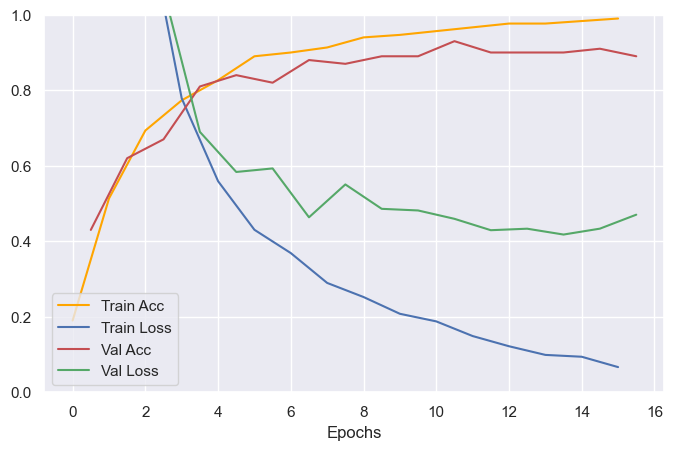

Epoch 1/20
10/10 [==============================] - 1s 28ms/step - loss: 2.0461 - accuracy: 0.3533 - val_loss: 1.6541 - val_accuracy: 0.5900
Epoch 2/20
10/10 [==============================] - 0s 12ms/step - loss: 1.3436 - accuracy: 0.6400 - val_loss: 1.0362 - val_accuracy: 0.7000
Epoch 3/20
10/10 [==============================] - 0s 12ms/step - loss: 0.8564 - accuracy: 0.7533 - val_loss: 0.8586 - val_accuracy: 0.7600
Epoch 4/20
10/10 [==============================] - 0s 13ms/step - loss: 0.6279 - accuracy: 0.8267 - val_loss: 0.6982 - val_accuracy: 0.7700
Epoch 5/20
10/10 [==============================] - 0s 13ms/step - loss: 0.5081 - accuracy: 0.8467 - val_loss: 0.6308 - val_accuracy: 0.8600
Epoch 6/20
10/10 [==============================] - 0s 12ms/step - loss: 0.3987 - accuracy: 0.8867 - val_loss: 0.5589 - val_accuracy: 0.7800
Epoch 7/20
10/10 [==============================] - 0s 13ms/step - loss: 0.3565 - accuracy: 0.9000 - val_loss: 0.5068 - val_accuracy: 0.8400
Epoch 8/20
10

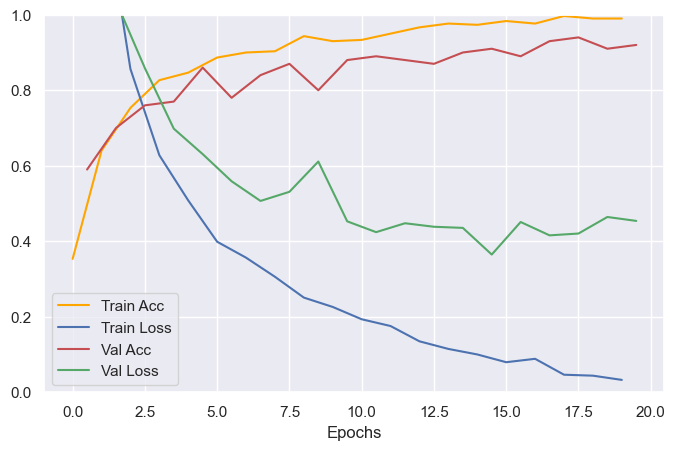

In [59]:
res=[]
for optimizer,lr in [[keras.optimizers.SGD,0.01], [???,???],  . . .  ]:
    valacc, history, discard = do_all(hiddensizes, actfn, optimizer, lr, n_train, n_valid, n_epochs, batch_size)
    plot_history(history)
    res += [[valacc]]

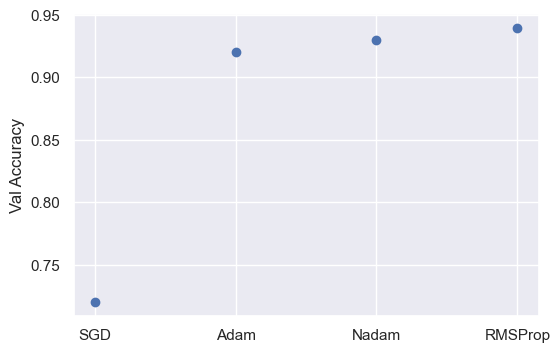

In [66]:
res=np.array(res)
plt.plot(res[:,0],'o')
plt.ylabel('Val Accuracy')
plt.xticks(ticks=[0,1,2,3],labels=['SGD','Adam','Nadam','RMSProp'])
plt.show()

# Your Tasks

Which one has the best final classifier? 

Which one converges fastest? 

Which learning curve is the smoothest?

Which one would you choose?

# Exploring learning rate schedules

Let us compare different learning rate schedules on the same task.

Epoch 1/50
10/10 [==============================] - 1s 23ms/step - loss: 2.3003 - accuracy: 0.1600 - val_loss: 2.2975 - val_accuracy: 0.2200 - lr: 1.0000e-07
Epoch 2/50
10/10 [==============================] - 0s 12ms/step - loss: 2.3003 - accuracy: 0.1600 - val_loss: 2.2975 - val_accuracy: 0.2200 - lr: 1.5849e-07
Epoch 3/50
10/10 [==============================] - 0s 12ms/step - loss: 2.3003 - accuracy: 0.1600 - val_loss: 2.2974 - val_accuracy: 0.2200 - lr: 2.5119e-07
Epoch 4/50
10/10 [==============================] - 0s 11ms/step - loss: 2.3002 - accuracy: 0.1633 - val_loss: 2.2973 - val_accuracy: 0.2200 - lr: 3.9811e-07
Epoch 5/50
10/10 [==============================] - 0s 12ms/step - loss: 2.3000 - accuracy: 0.1633 - val_loss: 2.2971 - val_accuracy: 0.2200 - lr: 6.3096e-07
Epoch 6/50
10/10 [==============================] - 0s 11ms/step - loss: 2.2998 - accuracy: 0.1633 - val_loss: 2.2968 - val_accuracy: 0.2200 - lr: 1.0000e-06
Epoch 7/50
10/10 [==============================] - 

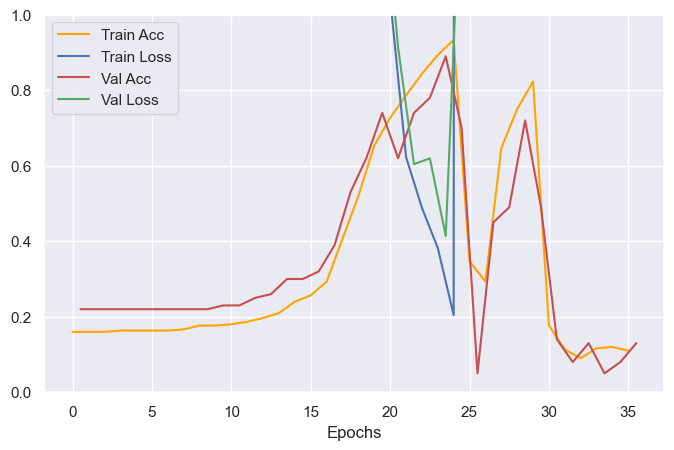

In [67]:
# Define scheduler functions
def exp_schedule(epoch):
    stretch=5
    return 0.0000001 * (10**(epoch/stretch))


early_stopping_cb2 = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=12, restore_best_weights=True) 

# Run with piecewise_const learning rate scheduler
optimizer=keras.optimizers.Nadam
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exp_schedule)
valacc, history, discard = do_all(hiddensizes, actfn, optimizer, learningrate, 
                                           n_train, n_valid, 50, batch_size,
                                           [lr_scheduler,early_stopping_cb2])
plot_history(history)

In [93]:
# Choose the epoch where things stop getting better and start becoming unstable
# Here I have chosen 22, which incorporates a safety margin of 1 or 2 epochs (this is a subjective choice)
maxlr=exp_schedule(22)
print(maxlr)

0.002511886431509582


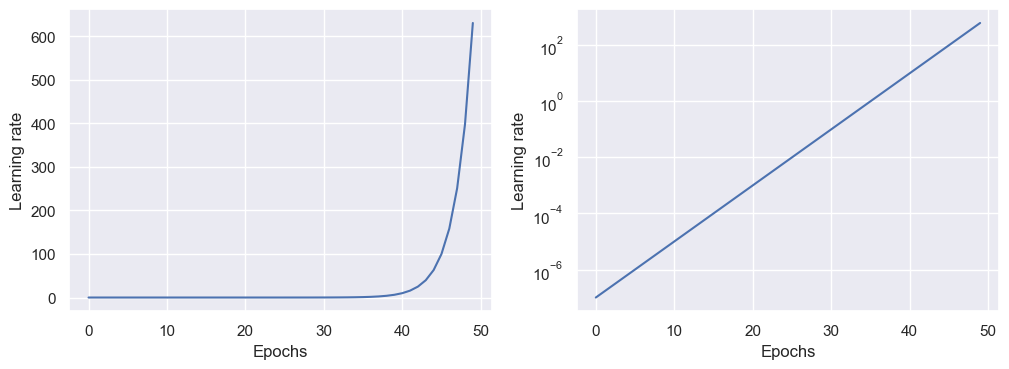

In [94]:
lrs=[]
for n in range(50):
        lrs = lrs + [exp_schedule(n)]
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
plt.plot(lrs)
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.subplot(1,2,2)
plt.semilogy(lrs)
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.show()

In [95]:
# Define scheduler functions
def OneCycleSchedule(epoch):
    maxepoch=20
    if epoch<maxepoch/2:
        lr=maxlr*(0.1 + (0.9*epoch/(maxepoch/2)))
    elif epoch<maxepoch:
        lr=maxlr*(1.9-0.9*epoch/(maxepoch/2))
    else:
        lr=0.1*maxlr
    return lr

## Comment
Note that the function above requires a value for maxlr as well, which is taken from the general environment, but it could have been set as an argument with a default value, since it must be able to be called with only one argument, as that is what the callback will do.

Epoch 1/20
10/10 [==============================] - 1s 24ms/step - loss: 2.2977 - accuracy: 0.1667 - val_loss: 2.2570 - val_accuracy: 0.3100 - lr: 2.5119e-04
Epoch 2/20
10/10 [==============================] - 0s 12ms/step - loss: 2.2304 - accuracy: 0.2800 - val_loss: 2.1634 - val_accuracy: 0.3500 - lr: 4.7726e-04
Epoch 3/20
10/10 [==============================] - 0s 11ms/step - loss: 2.0831 - accuracy: 0.3667 - val_loss: 1.9350 - val_accuracy: 0.5700 - lr: 7.0333e-04
Epoch 4/20
10/10 [==============================] - 0s 11ms/step - loss: 1.7301 - accuracy: 0.5700 - val_loss: 1.4033 - val_accuracy: 0.7300 - lr: 9.2940e-04
Epoch 5/20
10/10 [==============================] - 0s 12ms/step - loss: 1.0880 - accuracy: 0.7100 - val_loss: 0.8304 - val_accuracy: 0.7500 - lr: 0.0012
Epoch 6/20
10/10 [==============================] - 0s 12ms/step - loss: 0.6465 - accuracy: 0.8133 - val_loss: 0.6355 - val_accuracy: 0.8300 - lr: 0.0014
Epoch 7/20
10/10 [==============================] - 0s 11ms/

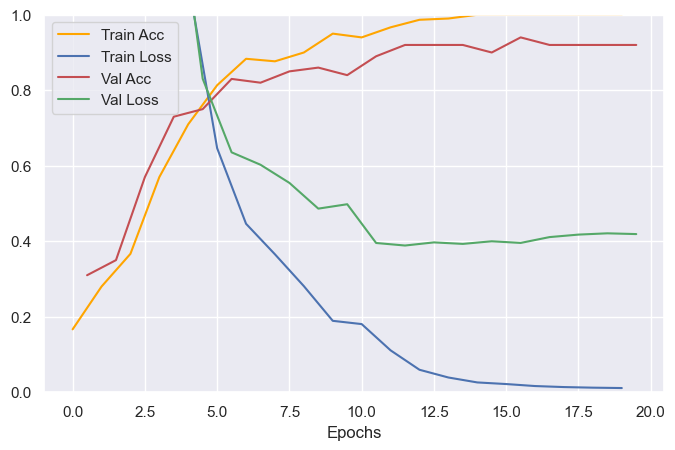

In [96]:
early_stopping_cb3 = keras.callbacks.EarlyStopping(monitor='???', patience=6, restore_best_weights=True) 

# Run with piecewise_const learning rate scheduler
optimizer=keras.optimizers.Nadam
lr_scheduler2 = tf.keras.callbacks.LearningRateScheduler(OneCycleSchedule)
valacc, history, discard = do_all(hiddensizes, actfn, optimizer, learningrate, 
                                           n_train, n_valid, n_epochs, batch_size,
                                           [lr_scheduler2,early_stopping_cb3])
print(f'Network configuration = {hiddensizes}')
plot_history(history)

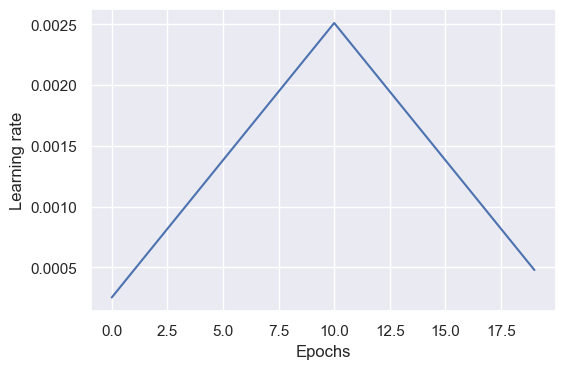

In [97]:
lrs=[]
for n in range(n_epochs):
        lrs = lrs + [OneCycleSchedule(n)]
plt.plot(lrs)
plt.xlabel('Epochs')
plt.ylabel('Learning rate')
plt.show()

## Comment
It can be seen that the learning is very effective, both efficient and achieving very good accuracy.  Hence this is a very good way of determining the learning rate, rather than having to do a more traditional type of search.

# Your Tasks: 

Write a new learning rate scheduler (copy from above and edit) that does a simple '1cycle' scheduling. Use the manual learning rate tests above *but with the Nadam optimizer* to choose a maximum learning rate. 

Manually experiment with the number of iterations for the upslope/down slope. 

Is the convergence faster than with a fixed learning rate?